In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Methods used
- MAFFT
- PASTA

### Datasets
1000M1, 1000M4, 16S.M

## 1. SPFN and SPFP analysis

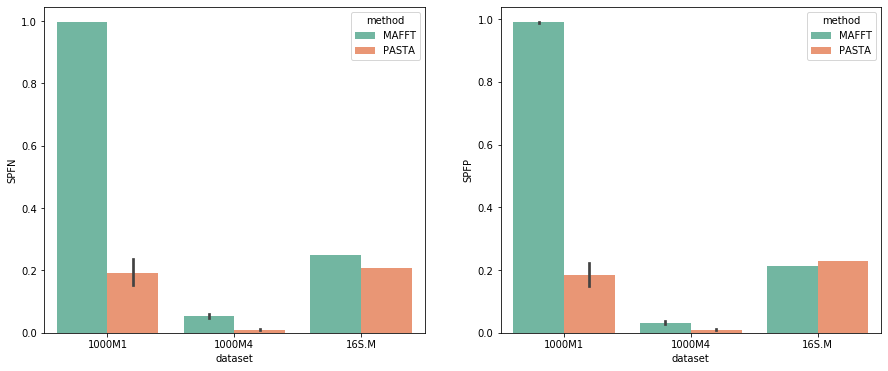

In [25]:
# read in fastsp.out files for each dataset per method
datasets = ['1000M1', '1000M4', '16S.M']
methods = ['MAFFT', 'PASTA']
reps = 10

df_list = []
for m in methods:
    #print("on method: {}".format(m))
    for d in datasets:
        #print("\ton dataset: {}".format(d))
        if d == '16S.M':
            path = '{}/{}/fastsp.out'.format(m, d)
            f = open(path, 'r').read().split('\n')
            spfn, spfp = float(f[2].split(' ')[1]), float(f[3].split(' ')[1])
            #print('\t\t'+str(spfn)+','+str(spfp))
            df_list.append([m, d, 'R0', spfn, spfp])
        else:
            # 1000M1 or 1000M4, then we have 10 repetitions for each
            for i in range(reps):
                path = '{}/{}/R{}/fastsp.out'.format(m, d, i)
                f = open(path, 'r').read().split('\n')
                spfn, spfp = float(f[2].split(' ')[1]), float(f[3].split(' ')[1])
                #print('\t\t'+str(spfn)+','+str(spfp))
                df_list.append([m, d, 'R{}'.format(i), spfn, spfp])

df = pd.DataFrame(df_list, columns=['method', 'dataset', 'rep', 'SPFN', 'SPFP'])
fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.barplot(x='dataset', y='SPFN', data=df, hue='method', palette="Set2", ax=ax[0])
sns.barplot(x='dataset', y='SPFP', data=df, hue='method', palette="Set2", ax=ax[1])
fig.savefig("eval_1.png", dpi=300)

## 2. FN FP analysis based on FastTree results of each estimated MSA

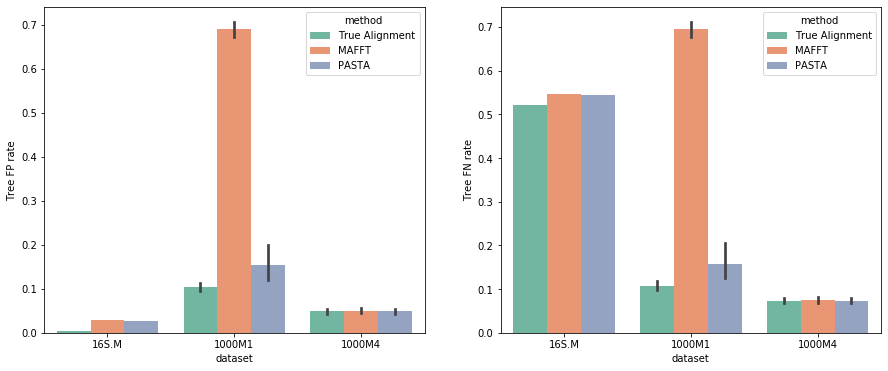

In [48]:
mafft_result = pd.read_csv('mafft/result_mafft.txt', header=0)
pasta_result = pd.read_csv('PASTA/result_pasta.txt', header=0)
mafft_result['method'] = 'MAFFT'
pasta_result['method'] = 'PASTA'

df = pd.concat([pasta_result, mafft_result], ignore_index=True)
df[['True Aln FP', 'True Aln FN', 'Est Aln FP', 'Est Aln FN', 'PASTA FN', 'PASTA FP']] = df[['True Aln FP', 'True Aln FN', 'Est Aln FP', 'Est Aln FN', 'PASTA FN', 'PASTA FP']].apply(pd.to_numeric)
df_gt = df.loc[df.method == 'PASTA', ['Dataset', 'True Aln FP', 'True Aln FN']]
df_gt = df_gt.rename(columns={"Dataset":'dataset', "True Aln FP":'Tree FP rate', "True Aln FN":'Tree FN rate'})
df_gt['method'] = 'True Alignment'
df_list = [df_gt]

# pull out both method and put them in list
for m in ['MAFFT', 'PASTA']:
    df_part = df.loc[df.method == m, ['Dataset', 'Est Aln FP', 'Est Aln FN', 'method']]
    df_part = df_part.rename(columns={"Dataset":'dataset', "Est Aln FP":'Tree FP rate', "Est Aln FN":'Tree FN rate', "method":'method'})
    df_list.append(df_part)

combined = pd.concat(df_list, ignore_index=True)
combined.loc[combined['dataset'] == '16S.M', 'Tree FP rate'] /= (901 - 3)
combined.loc[combined['dataset'] == '16S.M', 'Tree FN rate'] /= (901 - 3)
combined.loc[combined['dataset'] != '16S.M', 'Tree FP rate'] /= (1000 - 3)
combined.loc[combined['dataset'] != '16S.M', 'Tree FN rate'] /= (1000 - 3)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.barplot(x='dataset', y='Tree FP rate', data=combined, hue='method', palette="Set2", ax=ax[0])
sns.barplot(x='dataset', y='Tree FN rate', data=combined, hue='method', palette="Set2", ax=ax[1])

fig.savefig("eval_2.png", dpi=300)